In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2]:
# 1. 범주형 변수 확인
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num_cols = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
            'euribor3m', 'nr.employed']

from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
if 'duration' in X.columns:
    X = X.drop('duration', axis=1)


y = (df['y'] == 'yes').astype(int)  # yes=1, no=0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 3. Pipeline 구성
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

os.makedirs("outputs", exist_ok=True)

def _get_score(model, X):
    """ROC/PR 없이도 '가입 확률/점수'를 얻기 위한 함수(전략/우선순위에 필요)"""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        return proba[:, 1] if proba.ndim == 2 and proba.shape[1] >= 2 else proba
    if hasattr(model, "decision_function"):
        return model.decision_function(X)
    return model.predict(X)

def _get_feature_names_from_preproc(preproc, num_cols):
    """전처리 후 feature name 추출(마스터 preproc의 'cat' OHE 기준)"""
    try:
        cat_names = preproc.named_transformers_['cat'].get_feature_names_out()
        return list(num_cols) + list(cat_names)
    except Exception:
        return None


지도 학습 (가입 예측)

In [4]:
# =========================
# 성능 평가 지표 import
# =========================
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from viz_ml import fit_and_plot_all

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier


# =========================
# 지도학습 모델 정의
# → 어떤 머신러닝 알고리즘을 사용할지 목록 생성
# → 여러 모델을 같은 조건에서 비교하기 위함
# =========================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),   # 선형 확률 기반 분류 모델
    "Random Forest": RandomForestClassifier(),                  # 트리 앙상블(배깅)
    "XGBoost": XGBClassifier(),                                 # 부스팅 기반 고성능 모델
    "LightGBM": LGBMClassifier(),                               # 경량 부스팅 모델
    "Gradient Boosting": GradientBoostingClassifier(),          # 전통 부스팅
    "SVM": SVC(probability=True),                               # 마진 기반 분류
}


# [슬라이드 6] 상위 3개 모델 비교표 + 최고 성능 모델 선택

results = {}
fitted_models = {}

for name, clf in models.items():
    model = Pipeline([
        ('preproc', preproc),
        ('classifier', clf)
    ])
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # "가입(1)" 기준 성능을 저장(불균형이라 이게 핵심)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision(1)": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "Recall(1)": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        "F1(1)": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
    }
    fitted_models[name] = model

# 전체 결과표
results_df = pd.DataFrame(results).T.sort_values("Recall(1)", ascending=False)
display(results_df)

# 상위 3개만 슬라이드 6용 비교표로 출력
top3 = results_df.head(3)
display(top3)

# 최고 성능 모델 이름/모델 객체
best_model_name = top3.index[0]
best_model = fitted_models[best_model_name]
print("✅ 최고 성능 모델:", best_model_name)

# (선택) 발표용 한 줄
print("선정 기준: 불균형 데이터에서 가입(1) Recall 기준 최상")




[LightGBM] [Info] Number of positive: 3712, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 32950, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112656 -> initscore=-2.063898
[LightGBM] [Info] Start training from score -2.063898


,Accuracy,Precision(1),Recall(1),F1(1)
Random Forest,0.894999,0.563126,0.302802,0.393833
XGBoost,0.899247,0.610860,0.290948,0.394161
LightGBM,0.902646,0.667553,0.270474,0.384969
SVM,0.903496,0.695015,0.255388,0.373522
Gradient Boosting,0.901068,0.672783,0.237069,0.350598
Logistic Regression,0.900947,0.690476,0.218750,0.332242


,Accuracy,Precision(1),Recall(1),F1(1)
Random Forest,0.894999,0.563126,0.302802,0.393833
XGBoost,0.899247,0.610860,0.290948,0.394161
LightGBM,0.902646,0.667553,0.270474,0.384969


✅ 최고 성능 모델: Random Forest
선정 기준: 불균형 데이터에서 가입(1) Recall 기준 최상


In [ ]:
# =========================
# [슬라이드 6-1] Top3 모델 하이퍼파라미터 튜닝 + Recall 변화 비교
# =========================

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
import warnings
warnings.filterwarnings('ignore')

tuned_models = {}
recall_before_after = {}

# -------------------------------------------------
# 모델별 파라미터 공간 정의 함수
# -------------------------------------------------
def get_param_dist(model_name):

    # LightGBM
    if ("LightGBM" in model_name) or ("LGBM" in model_name):
        return {
            'classifier__n_estimators': randint(100, 500),
            'classifier__max_depth': [3, 5, 7, 10, -1],
            'classifier__learning_rate': uniform(0.01, 0.2),
            'classifier__num_leaves': randint(10, 100),
            'classifier__min_child_samples': randint(5, 50),
            'classifier__scale_pos_weight': randint(3, 20),
        }

    # XGBoost
    if ("XGBoost" in model_name) or ("XGB" in model_name):
        return {
            'classifier__n_estimators': randint(100, 500),
            'classifier__max_depth': randint(3, 10),
            'classifier__learning_rate': uniform(0.01, 0.2),
            'classifier__subsample': uniform(0.6, 0.4),
            'classifier__colsample_bytree': uniform(0.6, 0.4),
            'classifier__scale_pos_weight': randint(3, 20),
        }

    # RandomForest
    if ("Random Forest" in model_name) or ("RandomForest" in model_name):
        return {
            'classifier__n_estimators': randint(100, 600),
            'classifier__max_depth': [None, 5, 10, 20, 30],
            'classifier__min_samples_split': randint(2, 20),
            'classifier__min_samples_leaf': randint(1, 10),
            'classifier__max_features': ['sqrt', 'log2', None],
            'classifier__class_weight': [None, 'balanced'],
        }

    return None


# -------------------------------------------------
# Top3 모델 튜닝 루프
# -------------------------------------------------
for name in top3.index:

    print("\n" + "="*80)
    print(f"🔧 하이퍼파라미터 튜닝 시작 → {name}")

    # -------------------------
    # 기존 모델 Recall 측정
    # -------------------------
    base_model = fitted_models[name]
    y_pred_before = base_model.predict(X_test)
    rec_before = recall_score(y_test, y_pred_before, pos_label=1, zero_division=0)

    # -------------------------
    # 파라미터 공간 가져오기
    # -------------------------
    param_dist = get_param_dist(name)

    if param_dist is None:
        print(f"⚠️ {name} → 튜닝 파라미터 미정의 (스킵)")
        tuned_models[name] = base_model
        recall_before_after[name] = (rec_before, rec_before)
        continue

    # -------------------------
    # Pipeline 재구성
    # -------------------------
    base_clf = base_model.named_steps['classifier']

    pipe = Pipeline([
        ('preproc', preproc),
        ('classifier', base_clf.__class__(**base_clf.get_params()))
    ])

    # -------------------------
    # RandomizedSearchCV
    # -------------------------
    random_search = RandomizedSearchCV(
        pipe,
        param_dist,
        n_iter=40,
        cv=5,
        scoring='recall',     # 🔥 핵심: Recall 기준 튜닝
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_search.fit(X_train, y_train)

    tuned_model = random_search.best_estimator_
    tuned_models[name] = tuned_model

    # -------------------------
    # 튜닝 후 Recall 측정
    # -------------------------
    y_pred_after = tuned_model.predict(X_test)
    rec_after = recall_score(y_test, y_pred_after, pos_label=1, zero_division=0)

    recall_before_after[name] = (rec_before, rec_after)


# -------------------------------------------------
# Recall 변화 결과 출력 (글씨만)
# -------------------------------------------------
print("\n" + "="*80)
print("📊 Top3 모델 Recall 변화 비교 (튜닝 전 → 후)")
print("="*80)

for name, (before, after) in recall_before_after.items():

    diff = (after - before) * 100

    print(f"\n모델: {name}")
    print(f"- 튜닝 전 Recall: {before*100:.1f}%")
    print(f"- 튜닝 후 Recall: {after*100:.1f}%")

    if diff > 0:
        print(f"➡️ Recall {diff:.1f}% 상승")
    elif diff < 0:
        print(f"➡️ Recall {abs(diff):.1f}% 하락")
    else:
        print("➡️ Recall 변화 없음")


🔧 하이퍼파라미터 튜닝 시작 → Random Forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits

🔧 하이퍼파라미터 튜닝 시작 → XGBoost
Fitting 5 folds for each of 40 candidates, totalling 200 fits

🔧 하이퍼파라미터 튜닝 시작 → LightGBM
Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [ ]:
# [슬라이드 7] (튜닝된) 상위 3개 모델 성능 문구
import warnings
warnings.filterwarnings('ignore')

for name in top3.index:
    # tuned_models가 있으면 튜닝 모델, 없으면 기존 모델 사용
    if 'tuned_models' in globals() and name in tuned_models:
        m = tuned_models[name]
        tag = "튜닝"
    else:
        m = fitted_models[name]
        tag = "기본"

    y_pred = m.predict(X_test)

    prec1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f11  = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    print("\n" + "="*70)
    print(f"모델({tag}): {name}")
    if 'tuned_cv_best' in globals() and tuned_cv_best.get(name) is not None:
        print(f"- CV F1(best): {tuned_cv_best[name]:.4f}")
    print(f"- Precision(가입=1): {prec1*100:.1f}%")
    print(f"- Recall(가입=1): {rec1*100:.1f}%")
    print(f"- F1(가입=1): {f11:.3f}")
    print(f'- 문구: "가입자의 {rec1*100:.0f}%를 찾아냅니다!"')



모델(튜닝): Random Forest
- Precision(가입=1): 34.6%
- Recall(가입=1): 66.9%
- F1(가입=1): 0.456
- 문구: "가입자의 67%를 찾아냅니다!"

모델(튜닝): XGBoost
- Precision(가입=1): 18.0%
- Recall(가입=1): 83.5%
- F1(가입=1): 0.296
- 문구: "가입자의 84%를 찾아냅니다!"

모델(튜닝): LightGBM
- Precision(가입=1): 21.0%
- Recall(가입=1): 77.8%
- F1(가입=1): 0.331
- 문구: "가입자의 78%를 찾아냅니다!"


c:\Users\KDT53\miniconda3\envs\clean_ml\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [20]:
feat_names = _get_feature_names_from_preproc(
    best_model.named_steps['preproc'],
    num_cols
)

for i, name in enumerate(feat_names[:20]):
    print(f"f{i} → {name}")


f0 → age
f1 → campaign
f2 → pdays
f3 → previous
f4 → emp.var.rate
f5 → cons.price.idx
f6 → cons.conf.idx
f7 → euribor3m
f8 → nr.employed
f9 → job_admin.
f10 → job_blue-collar
f11 → job_entrepreneur
f12 → job_housemaid
f13 → job_management
f14 → job_retired
f15 → job_self-employed
f16 → job_services
f17 → job_student
f18 → job_technician
f19 → job_unemployed


,Permutation Importance
euribor3m,0.095905
nr.employed,0.094289
emp.var.rate,0.072872
pdays,0.045259
month,0.031789
contact,0.031385
cons.conf.idx,0.025323
job,0.016029
poutcome,0.015490
cons.price.idx,0.013066


"euribor3m" 변수가 가입 여부 예측에 가장 큰 영향을 미쳤습니다.


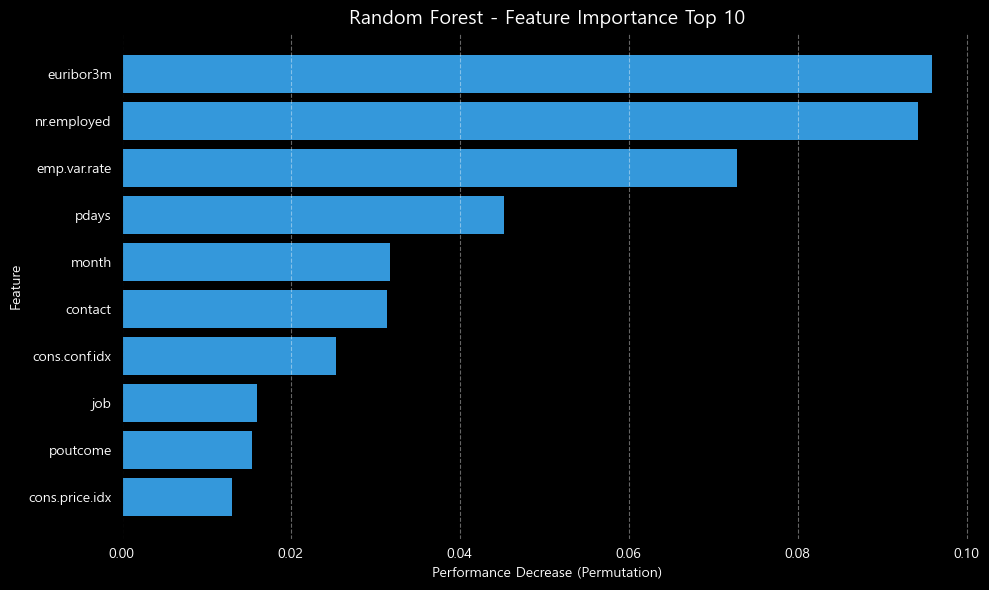

In [29]:
# [슬라이드 8] 중요변수 Top10 + 자동 문구 생성 (모델 종류 무관, KNN 가능)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# -----------------------------
# 중요도 계산 (Permutation)
# -----------------------------
perm = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring="recall",        # 가입자 기준 성능 영향
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)

# feature name
# perm은 X_test(원본 feature) 기준이므로, 이름도 X_test.columns를 씁니다.
if hasattr(X_test, "columns"):
    feat_names = list(X_test.columns)
else:
    feat_names = [f"f{i}" for i in range(len(perm.importances_mean))]

# 길이 검증(안 맞으면 강제로 맞춤)
feat_names = feat_names[:len(perm.importances_mean)]

imp_series = (
    pd.Series(perm.importances_mean, index=feat_names)
    .sort_values(ascending=False)
    .head(10)
)

# 중요도 정렬 Top10
imp_series = (
    pd.Series(perm.importances_mean, index=feat_names)
    .sort_values(ascending=False)
    .head(10)
)

display(imp_series.to_frame("Permutation Importance"))

# -----------------------------
# 가장 중요한 변수 자동 추출
# -----------------------------
most_important = imp_series.index[0]

# OHE 변수명 정리 (예: job_admin. → job)
clean_name = most_important.split("_")[0] if "_" in most_important else most_important

# -----------------------------
# 자동 발표 문구 생성
# -----------------------------
auto_sentence = f'"{clean_name}" 변수가 가입 여부 예측에 가장 큰 영향을 미쳤습니다.'
print(auto_sentence)

# -----------------------------
# 중요변수 Top10 그래프 시각화
# (슬라이드8 맨 밑에 삽입)
# -----------------------------

plt.figure(figsize=(10, 6), facecolor="black")

ax = plt.gca()
ax.set_facecolor("black")

plt.barh(
    imp_series.index[::-1],
    imp_series.values[::-1],
    color="#3498db"   # 막대 색은 취향
)

plt.title(
    f"{best_model_name} - Feature Importance Top 10",
    fontsize=14,
    color="white"
)

plt.xlabel("Performance Decrease (Permutation)", color="white")
plt.ylabel("Feature", color="white")

plt.xticks(color="white")
plt.yticks(color="white")

plt.grid(axis="x", linestyle="--", alpha=0.4, color="white")

plt.tight_layout()
plt.show()



In [22]:
# [슬라이드 9] 비즈니스 임팩트 (best_model 기준)
# 아래 2개 숫자만 마스터 상황에 맞게 채우면 "연간 XX억원 절감"이 자동 계산됩니다.

call_cost_won = 500     # (수정 가능) 전화 1통 비용(원) 예: 500원~2000원
annual_calls = 1000000  # (수정 가능) 연간 전화 시도 수(건) 예: 100만건

y_pred_best = best_model.predict(X_test)
y_score_best = _get_score(best_model, X_test)

baseline_rate = float(np.mean(y_test))  # 전체 대상 전화했을 때 성공률(베이스라인)

# 전략: 가입확률 상위 p%만 전화 (슬라이드에 가장 설득력 있음)
p = 0.30  # 상위 30%만 전화 (필요하면 0.2, 0.4 등으로 조정)
cut = np.quantile(y_score_best, 1 - p)
mask_top = (y_score_best >= cut)

target_calls = int(mask_top.sum())
target_rate = float(np.mean(y_test[mask_top])) if target_calls > 0 else 0.0

cost_reduction = 1 - (target_calls / len(y_test))             # 비용(전화량) 절감률
lift = (target_rate / baseline_rate) if baseline_rate > 0 else np.nan  # 성공률 향상 배수

# 연간 비용 절감(원) = 연간 콜 수 * 절감률 * 콜당 비용
annual_saving_won = annual_calls * cost_reduction * call_cost_won

print(f"- 비용(전화량) {cost_reduction*100:.0f}% 절감")
print(f"- 성공률 {baseline_rate*100:.1f}% → {target_rate*100:.1f}% (약 {lift:.1f}배 향상)")
print(f"- 연간 절감액: 약 {annual_saving_won/1e8:.2f} 억원 (가정: 콜당 {call_cost_won}원, 연간 {annual_calls:,}건)")


- 비용(전화량) 70% 절감
- 성공률 11.3% → 26.4% (약 2.3배 향상)
- 연간 절감액: 약 3.50 억원 (가정: 콜당 500원, 연간 1,000,000건)


In [23]:
# [슬라이드 10] 마케팅 전략 제안: 우선순위/최적 시기/맞춤 접근

# 1) 우선순위 결정: 가입확률(score)로 A/B/C 등급화
score_series = pd.Series(y_score_best, index=X_test.index, name="score")

tiers = pd.qcut(score_series, q=[0, 0.7, 0.9, 1.0], labels=["C(하)", "B(중)", "A(상)"])
tier_summary = pd.DataFrame({"tier": tiers, "y_true": y_test}).groupby("tier")["y_true"].mean().sort_index()

print("✅ 우선순위(등급)별 평균 가입률")
display(tier_summary.to_frame("가입률(평균)"))

print("- A등급: 최우선 콜(상담원 배정/집중)")
print("- B등급: 2순위(시간 여유 있을 때)")
print("- C등급: 저비용 채널(문자/이메일) 또는 재타겟")

# 2) 최적 시기: month / day_of_week 가입률 TOP (가능할 때만)
for col in ["month", "day_of_week"]:
    if hasattr(X_test, "columns") and col in X_test.columns:
        conv = pd.DataFrame({col: X_test[col], "y_true": y_test}).groupby(col)["y_true"].mean().sort_values(ascending=False)
        print(f"\n✅ {col}별 가입률 TOP 5")
        display(conv.head(5).to_frame("가입률"))
    else:
        print(f"\n⚠️ '{col}' 컬럼이 X_test에 없어 최적 시기 분석을 스킵합니다.")

# 3) 맞춤형 접근: 직업(job)별 가입률 TOP (가능할 때만)
if hasattr(X_test, "columns") and "job" in X_test.columns:
    conv_job = pd.DataFrame({"job": X_test["job"], "y_true": y_test}).groupby("job")["y_true"].mean().sort_values(ascending=False)
    print("\n✅ 직업(job)별 가입률 TOP 5")
    display(conv_job.head(5).to_frame("가입률"))
    print("제안: TOP 직업군에 맞춘 스크립트/상품 포인트 강화")
else:
    print("\n⚠️ 'job' 컬럼이 X_test에 없어 맞춤형 접근(직업별) 분석을 스킵합니다.")


✅ 우선순위(등급)별 평균 가입률


C:\Users\KDT53\AppData\Local\Temp\ipykernel_2768\16874050.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_summary = pd.DataFrame({"tier": tiers, "y_true": y_test}).groupby("tier")["y_true"].mean().sort_index()


,가입률(평균)
tier,
C(하),0.047834
B(중),0.151460
A(상),0.489078


- A등급: 최우선 콜(상담원 배정/집중)
- B등급: 2순위(시간 여유 있을 때)
- C등급: 저비용 채널(문자/이메일) 또는 재타겟

✅ month별 가입률 TOP 5


,가입률
month,
mar,0.536364
oct,0.465649
sep,0.462264
dec,0.435897
apr,0.204753



✅ day_of_week별 가입률 TOP 5


,가입률
day_of_week,
thu,0.125708
tue,0.124544
wed,0.121062
fri,0.103654
mon,0.087544



✅ 직업(job)별 가입률 TOP 5


,가입률
job,
student,0.353659
retired,0.242938
admin.,0.133776
unemployed,0.129630
technician,0.107967


제안: TOP 직업군에 맞춘 스크립트/상품 포인트 강화


In [24]:
# 결과 비교
import pandas as pd
pd.DataFrame(results).T

,Accuracy,Precision(1),Recall(1),F1(1)
Logistic Regression,0.900947,0.690476,0.218750,0.332242
Random Forest,0.895970,0.575053,0.293103,0.388294
XGBoost,0.899247,0.610860,0.290948,0.394161
LightGBM,0.902646,0.667553,0.270474,0.384969
Gradient Boosting,0.901068,0.672783,0.237069,0.350598
SVM,0.903496,0.695015,0.255388,0.373522


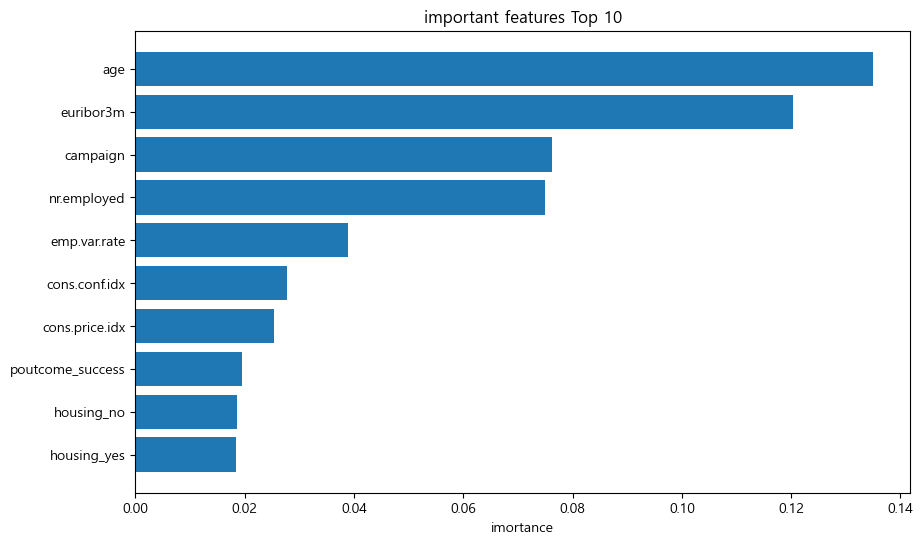

In [25]:
# Random Forest의 Feature Importance
model_rf = Pipeline([
    ('preproc', preproc),
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])
model_rf.fit(X_train, y_train)

# 특성 이름 추출
feature_names = (num_cols + 
                list(model_rf['preproc'].named_transformers_['cat'].get_feature_names_out()))

importances = model_rf['classifier'].feature_importances_
indices = np.argsort(importances)[-10:]  # 상위 10개

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[indices])
plt.yticks(range(10), np.array(feature_names)[indices])
plt.xlabel('imortance')
plt.title('important features Top 10')
plt.show()

In [26]:
total_calls = len(y_test)
total_success = y_test.sum()
success_rate_all = total_success / total_calls

print(f"전체 고객 전화: {total_calls}명")
print(f"성공: {total_success}명 ({success_rate_all*100:.1f}%)")

predicted_yes = (y_pred == 1)
targeted_calls = predicted_yes.sum()
targeted_success = (y_test[predicted_yes] == 1).sum()
success_rate_targeted = targeted_success / targeted_calls

print(f"\n모델 활용 (예측 가입자만 전화):")
print(f"전화: {targeted_calls}명 ({targeted_calls/total_calls*100:.1f}%)")
print(f"성공: {targeted_success}명")
print(f"성공률: {success_rate_targeted*100:.1f}%")

efficiency = success_rate_targeted / success_rate_all
print(f"\n효율성: {efficiency:.1f}배 향상!")


전체 고객 전화: 8238명
성공: 928명 (11.3%)

모델 활용 (예측 가입자만 전화):
전화: 3438명 (41.7%)
성공: 722명
성공률: 21.0%

효율성: 1.9배 향상!


In [27]:
best_model_name = results_df.index[0]
print("최종 선택 모델:", best_model_name)
print("선정 근거: Recall 기준 최상 + 불균형 데이터에서 1 클래스 성능 고려")


최종 선택 모델: Random Forest
선정 근거: Recall 기준 최상 + 불균형 데이터에서 1 클래스 성능 고려
